In [1]:
!rm -rf /content/sample_data

In [2]:
!gdown 1fli_hyDy7Io0coUNdk1P-DUPWtpfBwsX

Downloading...
From: https://drive.google.com/uc?id=1fli_hyDy7Io0coUNdk1P-DUPWtpfBwsX
To: /content/news-NLP.csv
100% 30.7M/30.7M [00:00<00:00, 31.7MB/s]


In [3]:
import pandas as pd
import gensim
from gensim.models import FastText
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [4]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [5]:
df = pd.read_csv('news-NLP.csv')
df = df.drop(df.columns[0], axis=1)

In [6]:
df['label'] = df['label'].apply(lambda x: 1 if x == "FAKE" else 0)
df['content'] = df['title'] + ' ' + df['text']

In [7]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [8]:
def preprocess_text(text):
    text = re.sub(r'\W', ' ', text)
    text = text.lower()
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return words

In [9]:
df['processed_content'] = df['content'].apply(preprocess_text)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.6858 - loss: 0.5880 - val_accuracy: 0.8028 - val_loss: 0.4400
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7989 - loss: 0.4465 - val_accuracy: 0.8156 - val_loss: 0.4313
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8785 - loss: 0.3204 - val_accuracy: 0.8294 - val_loss: 0.4106
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8950 - loss: 0.2760 - val_accuracy: 0.7890 - val_loss: 0.4277
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8826 - loss: 0.2800 - val_accuracy: 0.8393 - val_loss: 0.4127
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9384 - loss: 0.1830 - val_accuracy: 0.8452 - val_loss: 0.4286
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9418 - loss: 0.1741 - val_accuracy: 0.8284 - val_loss: 0.4476
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9400 - loss: 0.1761 - val_accuracy: 0.8185 - v

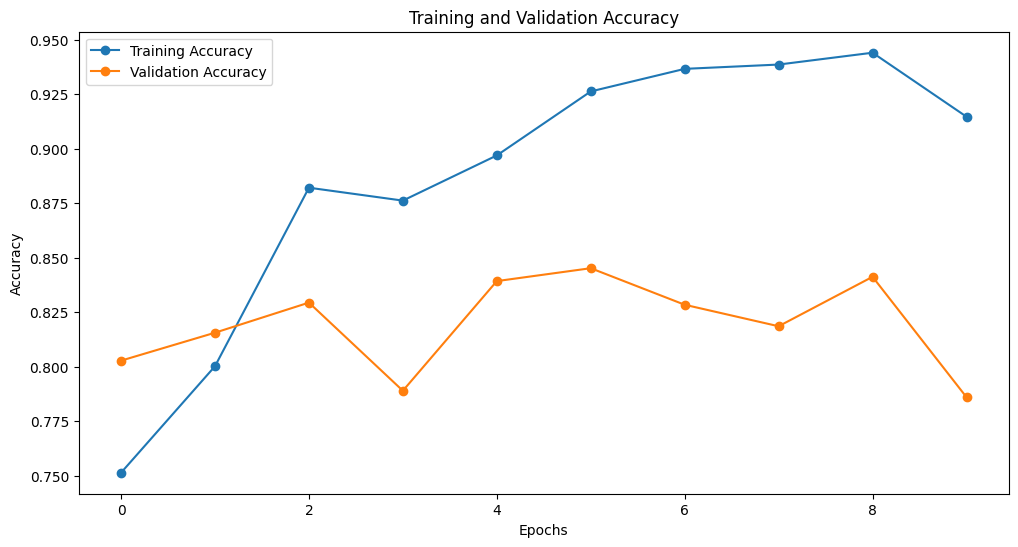

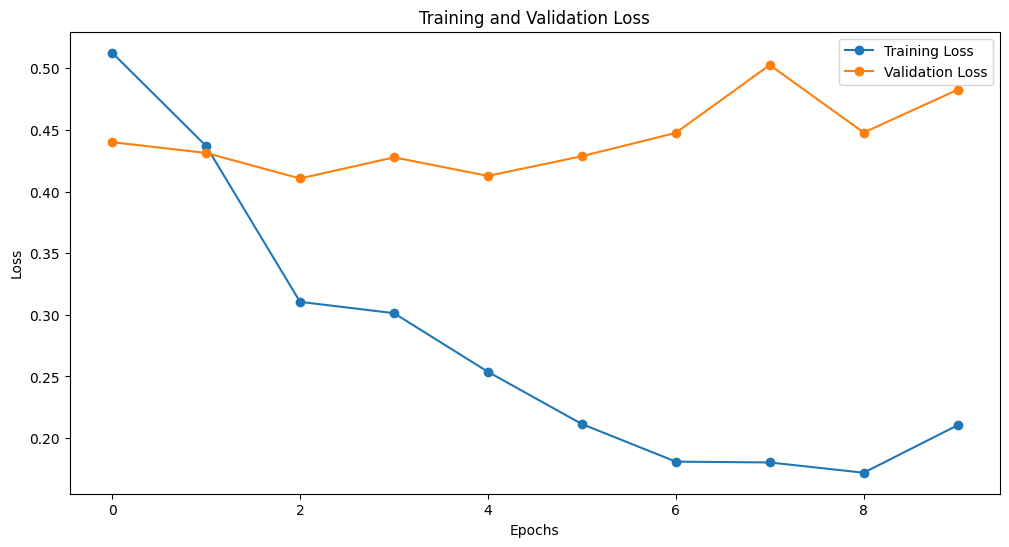

In [10]:
# Training FastText model on processed content
fasttext_model = FastText(
    sentences=df['processed_content'],
    vector_size=100,
    window=5,
    min_count=5,
    workers=4,
    sg=0,  # Skip-gram model
    epochs=10
)

# Create a dictionary mapping each word to its vector
embedding_matrix = np.zeros((len(fasttext_model.wv.key_to_index) + 1, 100))  # +1 for padding
word_index = {word: idx + 1 for idx, word in enumerate(fasttext_model.wv.key_to_index)}
for word, idx in word_index.items():
    embedding_matrix[idx] = fasttext_model.wv[word]

# Convert processed text into sequences of indices
def text_to_sequence(text, word_index):
    return [word_index[word] for word in text if word in word_index]

df['sequence'] = df['processed_content'].apply(lambda x: text_to_sequence(x, word_index))

# Padding sequences to the same length
max_seq_len = 200  # Adjust based on dataset analysis
X = pad_sequences(df['sequence'], maxlen=max_seq_len, padding='post')
y = df['label'].values

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Building the LSTM model
model = Sequential([
    Embedding(
        input_dim=len(embedding_matrix),
        output_dim=100,
        weights=[embedding_matrix],
        input_length=max_seq_len,
        trainable=False  # Freeze embedding layer
    ),
    LSTM(128, return_sequences=False),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training the model
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

# Evaluating the model
y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Plotting training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [11]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.7797947908445146
Precision: 0.7420249653259362
Recall: 0.8519108280254777
F1 Score: 0.793180133432172
